# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result

from networkx import Graph
from networkx.algorithms.approximation import min_weighted_dominating_set

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

[[-1  4  2 -2 -2 -4  0]
 [ 0 -2  4 -2 -2 -4 -2]
 [ 0  0 -1  0 -2 -4 -2]
 [ 0  0  0  3  0  0  0]
 [ 0  0  0  0  3  4  0]
 [ 0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  3]]


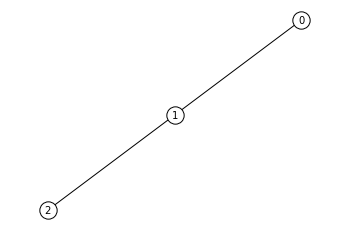

{'tag': 'simple',
 'total_vertices': 3,
 'total_edges': 2,
 'max_edges': 2,
 'adjacency': [[0, 1], [1, 2]],
 'adjacency_hash': '5c6af54e077bddcd12076955a2eee364'}

In [2]:
# Define Adjacency matrix
tag = "simple"
graph = {(0, 1), (1, 2)}
penalty = 1

directed = False
qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True)
print(qubo.todense())
gt.get_plot(graph, directed=directed)
plt.show()
graph_params = graph_summary(tag, graph)
graph_params

In [3]:
# DWave settings
dwave_config = {
    "annealing_time": 2000,  # integer microseconds [1, 2000]
    "answer_mode": "raw",
    "auto_scale": True,
    "num_reads": 2,  # raw will dump out all results
    "num_spin_reversal_transforms": 0,  # ask Travis what this is
    "readout_thermalization": 0, # default 0
    "programming_thermalization": 1000, # default 1000
    
}
solver = "DW_2000Q_5"

experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, qubo=qubo)
experiment_params

{'machine': 'DW_2000Q_5',
 'settings': {'annealing_time': 2000,
  'answer_mode': 'raw',
  'auto_scale': True,
  'num_reads': 2,
  'num_spin_reversal_transforms': 0,
  'readout_thermalization': 0,
  'programming_thermalization': 1000},
 'settings_hash': '7b7926e18c39dad05ef1fcf560678197',
 'p': 1,
 'qubo': [[-1, 4, 2, -2, -2, -4, 0],
  [0, -2, 4, -2, -2, -4, -2],
  [0, 0, -1, 0, -2, -4, -2],
  [0, 0, 0, 3, 0, 0, 0],
  [0, 0, 0, 0, 3, 4, 0],
  [0, 0, 0, 0, 0, 8, 0],
  [0, 0, 0, 0, 0, 0, 3]]}

In [7]:
# Solve on DWave and push to database
sampler = DWaveSampler(solver=solver)
embed = EmbeddingComposite(sampler)
qubo_dict = {key: val for key, val in zip(qubo.keys(), qubo.values())}
result = embed.sample_qubo(qubo_dict, **dwave_config)
raw = result.to_pandas_dataframe()
data_params = data_summary(raw, graph_params, experiment_params)
insert_result(graph_params, experiment_params, data_params)
data_params

<class 'qlpdb.data.models.Data'>
2
3 [1 1 0 1 0 0 0] 0.0 False
<class 'qlpdb.data.models.Data'>
3
4 [1 1 0 1 0 0 0] 0.0 False


{'spin_config': array([[1, 1, 0, 1, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0]], dtype=int8),
 'energy': array([0., 0.]),
 'constraint_satisfaction': array([False, False])}

In [5]:
vars(sampler)["_properties"].keys()

dict_keys(['num_qubits', 'qubits', 'couplers', 'h_range', 'j_range', 'supported_problem_types', 'parameters', 'vfyc', 'anneal_offset_ranges', 'anneal_offset_step', 'anneal_offset_step_phi0', 'annealing_time_range', 'chip_id', 'default_annealing_time', 'default_programming_thermalization', 'default_readout_thermalization', 'extended_j_range', 'h_gain_schedule_range', 'max_anneal_schedule_points', 'max_h_gain_schedule_points', 'num_reads_range', 'per_qubit_coupling_range', 'problem_run_duration_range', 'programming_thermalization_range', 'readout_thermalization_range', 'tags', 'topology', 'category', 'quota_conversion_rate'])

In [6]:
sampler._properties["default_programming_thermalization"]

1000